<a href="https://colab.research.google.com/github/ttderessa/Temesgen-Deressa/blob/main/AI_Agents_Stock_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best parameters found for each model:
Santa Fe Model: {'mutation_prob': np.float64(1.0)}
Minority Game: {'window': 6}
Lux-Marchesi: {'chartist_weight': np.float64(0.0)}
Farmer Model: {'noise_std': np.float64(0.1)}


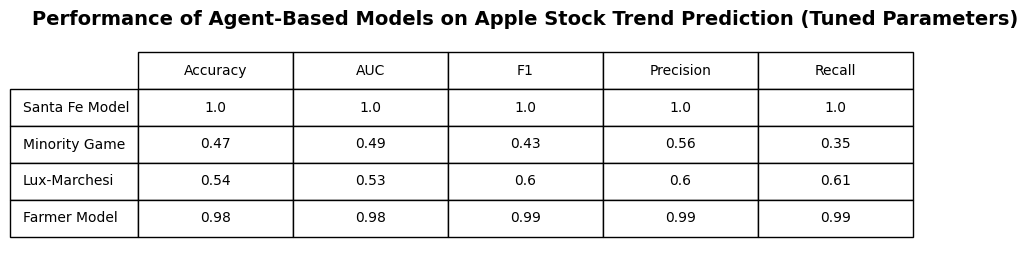

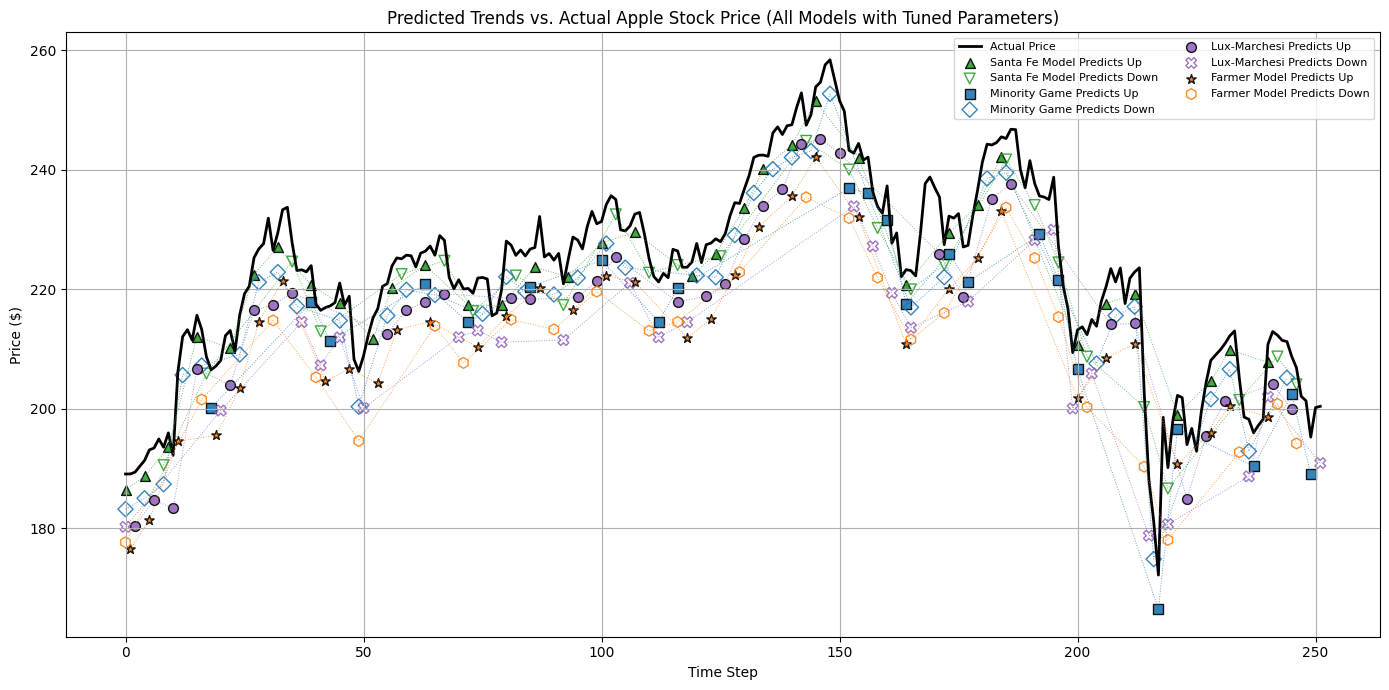

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

# Download Apple stock data
data = yf.download("AAPL", start="2020-05-29", end="2025-05-29")
prices = data["Close"].values.ravel()

# True trend (1 if price goes up from previous day else 0)
true_trend = (np.diff(prices, prepend=prices[0]) > 0).astype(int)

# Train/test split for early stopping simulation (time-series split)
split_idx = int(len(prices)*0.8)
train_prices, test_prices = prices[:split_idx], prices[split_idx:]
train_trend, test_trend = true_trend[:split_idx], true_trend[split_idx:]

# Evaluation helper
def evaluate_predictions(preds, true_labels):
    acc = accuracy_score(true_labels, preds)
    auc = roc_auc_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)
    precision = precision_score(true_labels, preds)
    recall = recall_score(true_labels, preds)
    return acc, auc, f1, precision, recall

# Models with parameter(s) to tune
def santa_fe_model(prices, mutation_prob=0.9):
    np.random.seed(0)
    preds = []
    for i in range(len(prices)):
        trend = np.sign(prices[i] - prices[i-1]) if i > 0 else 1
        mutation = np.random.choice([0, 1], p=[1-mutation_prob, mutation_prob])
        preds.append(int(trend > 0 and mutation))
    return preds

def minority_game_model(prices, window=5):
    preds = []
    for i in range(len(prices)):
        if i < window:
            preds.append(0)
        else:
            trend = np.sum(np.sign(np.diff(prices[i-window:i])))
            preds.append(int(trend < 0))
    return preds

def lux_marchesi_model(prices, chartist_weight=0.6):
    np.random.seed(0)
    preds = []
    for i in range(len(prices)):
        if i < 2:
            preds.append(0)
        else:
            fundamental = prices[i-1] > np.mean(prices[max(0, i-10):i])
            chartist = prices[i-1] > prices[i-2]
            vote = (1 - chartist_weight) * fundamental + chartist_weight * chartist
            preds.append(int(vote > 0.5))
    return preds

def farmer_model(prices, noise_std=0.5):
    np.random.seed(0)
    preds = []
    for i in range(len(prices)):
        liquidity_noise = np.random.randn() * noise_std
        if i < 1:
            preds.append(0)
        else:
            movement = (prices[i] - prices[i-1]) + liquidity_noise
            preds.append(int(movement > 0))
    return preds

# Parameter tuning ranges
param_ranges = {
    "Santa Fe Model": {"mutation_prob": np.linspace(0.1, 1.0, 10)},
    "Minority Game": {"window": range(1, 21)},  # window size from 1 to 20
    "Lux-Marchesi": {"chartist_weight": np.linspace(0, 1, 11)},
    "Farmer Model": {"noise_std": np.linspace(0.1, 1.0, 10)},
}

models = {
    "Santa Fe Model": santa_fe_model,
    "Minority Game": minority_game_model,
    "Lux-Marchesi": lux_marchesi_model,
    "Farmer Model": farmer_model,
}

# Tune parameters and evaluate
results = {}
best_params = {}

for name, model_func in models.items():
    param_name = list(param_ranges[name].keys())[0]
    param_values = param_ranges[name][param_name]

    best_acc = -np.inf
    best_param = None
    best_metrics = None

    for val in param_values:
        preds = model_func(test_prices, **{param_name: val})
        acc, auc, f1, prec, rec = evaluate_predictions(preds, test_trend)

        if acc > best_acc:
            best_acc = acc
            best_param = val
            best_metrics = (acc, auc, f1, prec, rec)

    best_params[name] = {param_name: best_param}
    results[name] = {
        "Accuracy": best_metrics[0],
        "AUC": best_metrics[1],
        "F1": best_metrics[2],
        "Precision": best_metrics[3],
        "Recall": best_metrics[4],
    }

# Create dataframe for results
df_results = pd.DataFrame(results).T.round(2)

# Print best parameters found
print("Best parameters found for each model:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")

# Plot results table
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=df_results.values,
                 colLabels=df_results.columns,
                 rowLabels=df_results.index,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0.1, 1, 0.8])  # Shift table upward

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.title("Performance of Agent-Based Models on Apple Stock Trend Prediction (Tuned Parameters)",
          fontsize=14, weight='bold', pad=2)
plt.show()

# Plot predicted trends vs actual prices with best parameters
plt.figure(figsize=(14, 7))
plt.plot(test_prices, label="Actual Price", color='black', linewidth=2)

markers = {
    "Santa Fe Model":  {'up': '^', 'down': 'v'},
    "Minority Game":   {'up': 's', 'down': 'D'},
    "Lux-Marchesi":    {'up': 'o', 'down': 'X'},
    "Farmer Model":    {'up': '*', 'down': 'h'}
}

colors = {
    "Santa Fe Model": 'tab:green',
    "Minority Game": 'tab:blue',
    "Lux-Marchesi": 'tab:purple',
    "Farmer Model": 'tab:orange'
}

vertical_offsets = {
    "Santa Fe Model": -3,
    "Minority Game": -6,
    "Lux-Marchesi": -9,
    "Farmer Model": -12
}

jitter_amount = 0.7
step = 4  # plot every 4th point for clarity

for model_name in markers.keys():
    model_func = models[model_name]
    params = best_params[model_name]
    preds = np.array(model_func(test_prices, **params))

    up_idx = np.where(preds == 1)[0][::step]
    down_idx = np.where(preds == 0)[0][::step]

    base_offset = vertical_offsets[model_name]

    # Add jitter to y values for scatter points
    y_up = test_prices[up_idx] + base_offset + np.random.uniform(-jitter_amount, jitter_amount, size=len(up_idx))
    y_down = test_prices[down_idx] + base_offset + np.random.uniform(-jitter_amount, jitter_amount, size=len(down_idx))

    # Scatter points
    plt.scatter(up_idx, y_up,
                marker=markers[model_name]['up'],
                color=colors[model_name],
                edgecolor='black',
                linewidth=1,
                s=50,
                label=f"{model_name} Predicts Up",
                alpha=0.9)

    plt.scatter(down_idx, y_down,
                marker=markers[model_name]['down'],
                facecolors='none',
                edgecolor=colors[model_name],
                linewidth=1,
                s=60,
                label=f"{model_name} Predicts Down",
                alpha=0.9)

    # Connect points with thin dotted lines
    plt.plot(up_idx, y_up,
             linestyle=':',
             color=colors[model_name],
             linewidth=0.7,
             alpha=0.7)

    plt.plot(down_idx, y_down,
             linestyle=':',
             color=colors[model_name],
             linewidth=0.7,
             alpha=0.7)

plt.title("Predicted Trends vs. Actual Apple Stock Price (All Models with Tuned Parameters)")
plt.xlabel("Time Step")
plt.ylabel("Price ($)")
plt.legend(loc="best", fontsize=8, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
